<a href="https://colab.research.google.com/github/eric-sun92/pytorch_intro/blob/01_pytorch_workflow/01_pytorch_workflow_runthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

#create device-agnostic code. use GPU if available


device = 'cuda' if torch.cuda.is_available() else "cpu"


In [3]:
!nvidia-smi

Sat May 27 16:53:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# DATA 
weight = 0.9
bias = 0.2

start = 0
end = 1
step = 0.02

#create x and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


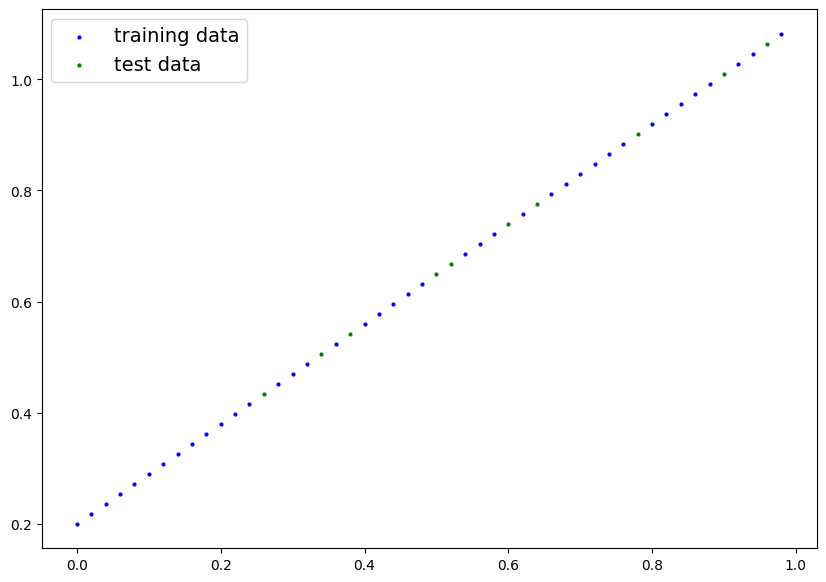

In [5]:
# plot data

def plot_predictions(X_train=X_train, 
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      predictions=None):
  plt.figure(figsize=(10, 7))
  
  plt.scatter(X_train, y_train, c="b", s=4, label="training data")

  plt.scatter(X_test, y_test, c="g", s=4, label="test data")

  if predictions is not None:
    plt.scatter(X_test, predictions, c="r", s=4, label="predictions")

  plt.legend(prop={"size": 14})


plot_predictions()

In [6]:
#building a model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


model_01 = LinearRegressionModel()

model_01, model_01.state_dict()


(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [7]:
# set model to target device

device

'cuda'

In [12]:
# put model and data on device
model_01.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [9]:
next(model_01.parameters()).device

device(type='cuda', index=0)

In [13]:
# Training -> loss function, optimizer function

loss_fn = nn.L1Loss()

learning_rate = 0.01
optimizer = torch.optim.SGD(params=model_01.parameters(), lr=learning_rate)

# training loop
torch.manual_seed(42)
num_epochs = 200

for epoch in range(num_epochs):

  model_01.train()

  y_pred = model_01(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_01.eval()
  with torch.inference_mode():
    test_pred = model_01(X_test)

    test_loss = loss_fn(test_pred, y_test)
  
  if epoch % 10 == 0:
    print(f"epoch: {epoch + 1} | loss: {loss} | testLoss: {test_loss}")



epoch: 1 | loss: 0.5669506192207336 | testLoss: 0.5376195311546326
epoch: 11 | loss: 0.4452817142009735 | testLoss: 0.4102481007575989
epoch: 21 | loss: 0.3236127197742462 | testLoss: 0.28287678956985474
epoch: 31 | loss: 0.2019437849521637 | testLoss: 0.1555054634809494
epoch: 41 | loss: 0.10958810895681381 | testLoss: 0.07546550035476685
epoch: 51 | loss: 0.09053169935941696 | testLoss: 0.06020322069525719
epoch: 61 | loss: 0.08198826014995575 | testLoss: 0.055671822279691696
epoch: 71 | loss: 0.0757984146475792 | testLoss: 0.05241001769900322
epoch: 81 | loss: 0.07010593265295029 | testLoss: 0.04873275011777878
epoch: 91 | loss: 0.06452774256467819 | testLoss: 0.04480169713497162
epoch: 101 | loss: 0.058942582458257675 | testLoss: 0.040870632976293564
epoch: 111 | loss: 0.053365327417850494 | testLoss: 0.03699033334851265
epoch: 121 | loss: 0.047780152410268784 | testLoss: 0.033059265464544296
epoch: 131 | loss: 0.0422029085457325 | testLoss: 0.029178975149989128
epoch: 141 | loss: 

In [14]:
model_01.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.8882]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2060], device='cuda:0'))])

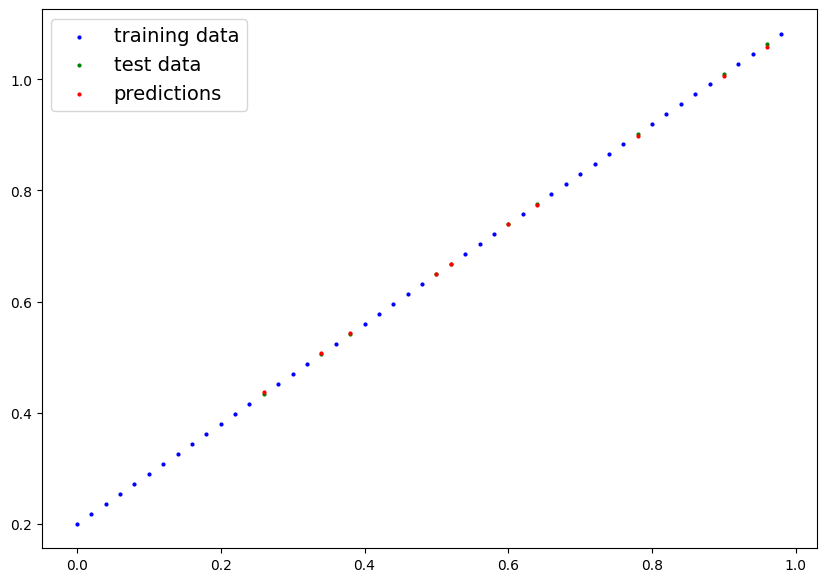

In [16]:
with torch.inference_mode():
  y_pred_plot = model_01(X_test)

plot_predictions(predictions=y_pred_plot.cpu())


In [17]:
## save the model
from pathlib import Path

# make dir
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)


MODEL_NAME = '01_pytorch_workflow_model_01.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_01.state_dict(), 
           f=MODEL_SAVE_PATH)


saving model to: models/01_pytorch_workflow_model_01.pth


In [18]:
# load the model back up

# create new instanct of lin reg model
model_01_loaded = LinearRegressionModel()

# load the saved model_1 state dict
model_01_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

# send model to device
model_01_loaded.to(device)



LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

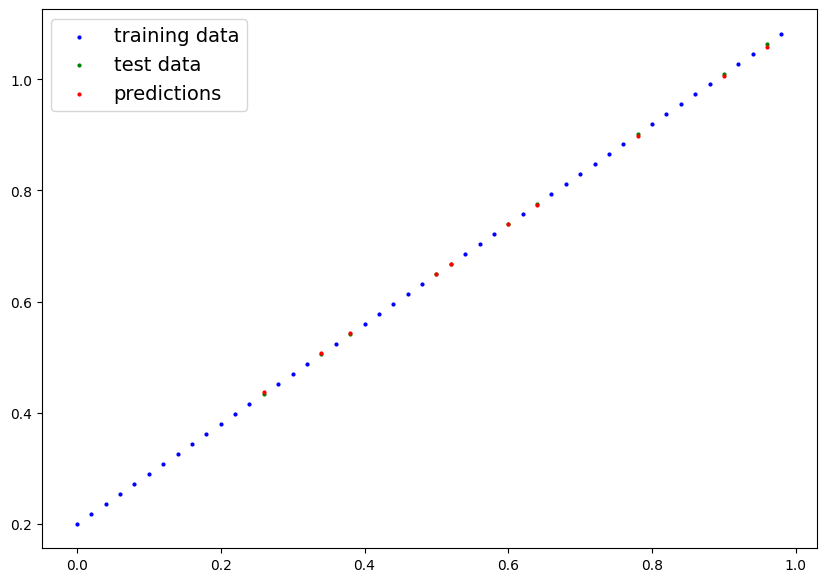

In [21]:
model_01_loaded.eval()

with torch.inference_mode():
  y_loaded_pred = model_01_loaded(X_test)

plot_predictions(predictions=y_loaded_pred.cpu())
